<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F3D8F5;">

# What is the inhibitory connectivity underlying surround suppression in the mouse primary visual cortex?

## Background
Surround suppression is a feature of sensory processing which, in visual systems, facilitates the definition of objects against their backgrounds (Kiniklioglu & Kaiser, 2025) by sharpening receptive fields as suppression strength increases (Plomp et al., 2019). While much work has been directed to describing the functional aspect of surround suppression, the underlying inhibitory structural connectivity has received less attention. We propose the use of the V1DD dataset, which comprises both structural and functional data, to address several questions about the inhibitory connectivity subserving surround suppression across the layers of the mouse primary visual cortex. 
    
## Methods
### Feature extraction:
Morphological metrics: total axonal length/radius, branch counts, maximum branch order, output synapse counts, synaptic density per unit length, number of distinct target types, layer/radial distributions, soma depth
Activity metrics: Differences in ΔF/F for windowed gabor - full-field gabor, suppression index
Synapse spatial targeting: Comparison of SOM+ vs other inhibitory interneurons for probability of synapsing
    
## Statistics:
Make a null connectivity model (by shuffling connections between cells): If the cell is connected to the inhibitory cells, then this cell may be more functionally capable of doing surround suppression, and the cells that could have been connected to inhibitory cells, will be less capable. Whether this is actually the case is unclear, and making a null connectivity model will help with this question.
Spearman correlation for cell connectivity probabilities? Maybe could do paired tests, depends on the final form of data.


In [1]:
# Import packages
import sys
import os
from os.path import join as pjoin
import platform

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from standard_transform.datasets import v1dd_ds

# Add the directory for the data and utilities
mat_version = 1196

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_root = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2025/"

# Set the directory to load prepared data and utility code
data_dir = pjoin(data_root, f"v1dd_{mat_version}")
utils_dir = pjoin("..", "utils")

# Add utilities to path
sys.path.append(utils_dir)
from data_io import *
from utils import filter_synapse_table, check_index, adjacencyplot, calculate_lateral_distances
from data_io import _get_data_dir

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
Load proofreading information about cells:
</div>

In [2]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_dendrite_list_{mat_version}.npy")
)
axon_proof_root_ids = np.load(pjoin(data_dir, f"proofread_axon_list_{mat_version}.npy"))

proofread_ids = np.intersect1d(dendrite_proof_root_ids, axon_proof_root_ids)

proofread_ids

array([864691132534275418, 864691132534315610, 864691132535664474, ...,
       864691133313558608, 864691133313636944, 864691133313665616],
      shape=(1148,))

In [3]:
# Load synapses 
# syn_df = syn_df = pd.read_feather(f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")
syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather"
).set_index("id")

print(f"Cells collected: {len(syn_df)}")

# Load target information
target_structure = pd.read_feather(
    pjoin(data_dir, f"syn_label_df_all_to_proofread_to_all_{mat_version}.feather")
)["tag"]

# Combine the target information to the proofread synapses table
syn_df["target_structure"] = target_structure
syn_df["target_structure"] = syn_df["target_structure"].fillna("unknown")
syn_df.head()


Cells collected: 8204497


,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,target_structure
id,,,,,,,,,,,,,
354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083,shaft
378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301,shaft
499493001,977071.3,390075.8,191340.0,976974.3,390104.9,190935.0,976838.5,390337.7,190935.0,1346,864691132573738810,864691132747578447,unknown
119675985,444260.0,602544.6,3285.0,443988.4,602311.8,3555.0,444182.4,602370.0,3780.0,3637,864691132572564252,864691132654028028,unknown
220616943,574501.9,337249.6,258570.0,574152.7,337016.8,258570.0,574337.0,336900.4,258570.0,420,864691132558380553,864691132828255906,unknown


In [4]:
# filter synapses between proofread cells
# filter presynaptic neurons with axonal proofreading and postsyn neurons with dendrite proofreading

proof_syn_df = filter_synapse_table(syn_df, axon_proof_root_ids, dendrite_proof_root_ids)

proof_syn_df = proof_syn_df.copy()

print(f"Cells filtered: {len(proof_syn_df)}")

proof_syn_df.head()

Cells filtered: 1500254


,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,target_structure
id,,,,,,,,,,,,,
354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083,shaft
378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301,shaft
560121937,1054031.1,711388.3,323010.0,1054234.8,711417.4,323100.0,1054147.5,711368.9,323010.0,440,864691132558474249,864691132640932240,shaft
383733788,801520.7,622167.7,347040.0,801501.3,622322.9,347085.0,801530.4,622235.6,347175.0,3012,864691132572056604,864691132829783452,spine
473999443,926573.1,686275.0,222615.0,926447.0,685809.4,222570.0,926408.2,686061.6,222615.0,133,864691132558474249,864691132786392972,spine


In [5]:
# Mark proofread neurons in the synapse dataframe so we can filter out everything else for connectivity analysis
proof_syn_df["pre_proofread"] = proof_syn_df["pre_pt_root_id"].isin(axon_proof_root_ids)
proof_syn_df["post_proofread"] = proof_syn_df["post_pt_root_id"].isin(dendrite_proof_root_ids)

# These are approximate depth values in post-transformed microns for the pial surface, L1-L2/3 border, L2/3-L4 border, etc. down to the L6-wm border.
layer_bounds = [
    -15,
    91,
    261,
    391,
    537,
    753,
]  

In [6]:
# load the cell type information
ct_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")

# Convert from nanometers to microns
ct_df["soma_depth"] = (
    ct_df["pt_position_trform_y"] / 1_000
)  

# Approximate cell depth from pial surface in microns
ct_df["pt_position_trform_x"] =ct_df["pt_position_trform_x"] / 1_000
ct_df["pt_position_trform_y"] =ct_df["pt_position_trform_y"] / 1_000
ct_df["pt_position_trform_z"] =ct_df["pt_position_trform_z"] / 1_000

ct_df.head() 

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type,soma_depth
0,228132,632828,749849,738270,-323.721448,549.910283,392.909833,864691132737039043,458.464831,None,None,549.910283
1,543247,1304922,977915,83880,330.339020,595.962276,-306.424551,864691132730839988,73.345940,None,None,595.962276
2,203262,624680,531094,283770,-252.082628,203.770728,21.544030,864691132654552792,338.276613,E,L3-IT,203.770728
3,350562,894573,478559,163530,20.989259,117.514626,-98.554035,864691132773514104,326.965400,E,L2-IT,117.514626
4,718122,1729859,674111,781200,803.635727,475.075415,467.669881,864691132774106773,333.888647,None,None,475.075415


In [7]:
# What we are about to do requres that no root ids are duplicated in this, so let's double check:
ct_df.drop_duplicates("pt_root_id", keep=False, inplace=True)

In [8]:
# Add proofreading information
ct_df["is_axon_proofread"] = ct_df["pt_root_id"].isin(axon_proof_root_ids)
ct_df["is_dendrite_proofread"] = ct_df["pt_root_id"].isin(dendrite_proof_root_ids)
ct_df.head(5)

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type,soma_depth,is_axon_proofread,is_dendrite_proofread
2,203262,624680,531094,283770,-252.082628,203.770728,21.544030,864691132654552792,338.276613,E,L3-IT,203.770728,False,True
3,350562,894573,478559,163530,20.989259,117.514626,-98.554035,864691132773514104,326.965400,E,L2-IT,117.514626,False,True
4,718122,1729859,674111,781200,803.635727,475.075415,467.669881,864691132774106773,333.888647,None,None,475.075415,False,False
5,680726,1640231,677370,768015,713.993992,475.136490,454.028344,864691132780109973,706.847075,None,None,475.136490,False,False
6,544582,1316562,974035,157590,334.827644,613.565716,-236.450684,864691132736203675,200.069363,None,None,613.565716,False,False


In [9]:
# Add the synapse depth in consistent coordinates
proof_syn_df["synapse_depth"] = v1dd_ds.transform_nm.apply_dataframe(
    "ctr_pt_position", proof_syn_df, projection="y"
)

proof_syn_df.head(5)

,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,target_structure,pre_proofread,post_proofread,synapse_depth
id,,,,,,,,,,,,,,,,
354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083,shaft,True,True,465.734071
378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301,shaft,True,True,155.489291
560121937,1054031.1,711388.3,323010.0,1054234.8,711417.4,323100.0,1054147.5,711368.9,323010.0,440,864691132558474249,864691132640932240,shaft,True,True,381.348665
383733788,801520.7,622167.7,347040.0,801501.3,622322.9,347085.0,801530.4,622235.6,347175.0,3012,864691132572056604,864691132829783452,spine,True,True,303.195324
473999443,926573.1,686275.0,222615.0,926447.0,685809.4,222570.0,926408.2,686061.6,222615.0,133,864691132558474249,864691132786392972,spine,True,True,330.726891


In [ ]:
# add the postsynaptic euclidean distance from the presynaptic cell/neuron

def add_euclidean_distance(df, x1='x1', x2='x2',y1='y1', y2='y2',z1='z1', z2='z2', new_col='distance'):
    """
    Calculate Euclidean distance from origin (0,0,0) for x, y, z coordinates in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing x, y, z coordinate columns.
    x_col, y_col, z_col : str
        Names of the columns for x, y, z coordinates.
    new_col : str
        Name of the new column to store distances.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with an additional column containing Euclidean distances.
    """
    x_col = x1-x2
    y_col = y1-y2 
    z_col = z1-z2
    df[new_col] = np.sqrt(df[x_col]**2 + df[y_col]**2 + df[z_col]**2)
    return df


In [11]:
# copy the synapses dataframe
#ct_df_ecldn = ct_df.copy()
#ct_df_ecldn.head(5)

In [12]:
# compute the euclidean distance for each post_pt_root_id
#syn_df_ecldn = calculate_euclidean_distance(syn_df_ecldn, x1_col ='post_pt_position_x', y1_col ='post_pt_position_y', z1_col='post_pt_position_z',
#                                      x2_col='pre_pt_position_x', y2_col ='pre_pt_position_y', z2_col ='pre_pt_position_z',new_col='euclidean_distance')
#syn_df_ecldn.head()

In [ ]:
#type(syn_df_ecldn["pre_pt_root_id"])

In [14]:
# Let's make a dataframe where each row is a "connection" between a presynaptic and postsynaptic neuron, with the number of synapses and their summed size as two different measures of the connection weight.
# This involves a "group-by" on both the presynaptic and postsynaptic neuron IDs and aggregating both the count of synapses, summed synapse size, average euclidean distance.

connectivity_df = (
    proof_syn_df.query("pre_proofread or post_proofread")
    .groupby(["pre_pt_root_id", "post_pt_root_id","target_structure"])
    .agg(num_synapses=("pre_pt_root_id", "count"), sum_size=("size", "sum"))
    .reset_index()
)

connectivity_df.head()

,pre_pt_root_id,post_pt_root_id,target_structure,num_synapses,sum_size
0,864691132534275418,864691132545971778,spine,1,839
1,864691132534275418,864691132555074569,spine,1,1363
2,864691132534275418,864691132557993993,shaft,2,4299
3,864691132534275418,864691132559315940,shaft,2,1683
4,864691132534275418,864691132565101518,shaft,1,1667


In [15]:
# add the synaptic ratio - divide sum_size by number of synapses
connectivity_df["synaptic_ratio"] = connectivity_df["sum_size"]/connectivity_df["num_synapses"]
connectivity_df.head()

,pre_pt_root_id,post_pt_root_id,target_structure,num_synapses,sum_size,synaptic_ratio
0,864691132534275418,864691132545971778,spine,1,839,839.0
1,864691132534275418,864691132555074569,spine,1,1363,1363.0
2,864691132534275418,864691132557993993,shaft,2,4299,2149.5
3,864691132534275418,864691132559315940,shaft,2,1683,841.5
4,864691132534275418,864691132565101518,shaft,1,1667,1667.0


In [16]:
# Swap column 'synaptic_ratio' to the fourth position
# col = connectivity_df.pop('synaptic_ratio')
# connectivity_df.insert(5, 'synaptic_ratio', col)

# Swap columns
connectivity_df = connectivity_df[['pre_pt_root_id', 'post_pt_root_id', 'num_synapses',
                                  'sum_size', 'synaptic_ratio', 'target_structure']]

#col2 = connectivity_df.pop('target_structure')
#connectivity_df.insert(6,'target_structure', col2)

connectivity_df.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,target_structure
0,864691132534275418,864691132545971778,1,839,839.0,spine
1,864691132534275418,864691132555074569,1,1363,1363.0,spine
2,864691132534275418,864691132557993993,2,4299,2149.5,shaft
3,864691132534275418,864691132559315940,2,1683,841.5,shaft
4,864691132534275418,864691132565101518,1,1667,1667.0,shaft


In [17]:
# check cell table for 
ct_df.columns

Index(['id', 'pt_position_x', 'pt_position_y', 'pt_position_z',
       'pt_position_trform_x', 'pt_position_trform_y', 'pt_position_trform_z',
       'pt_root_id', 'volume', 'cell_type_coarse', 'cell_type', 'soma_depth',
       'is_axon_proofread', 'is_dendrite_proofread'],
      dtype='object')

In [20]:
# Merge with the cell type dataframe

connectivity_ct_df = connectivity_df.merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type",
          "pt_position_trform_x", "pt_position_trform_y", "pt_position_trform_z"]].rename(
        columns={
            "pt_root_id": "pre_pt_root_id",
            "soma_depth": "soma_depth_pre",
            "cell_type": "cell_type_pre",
            "cell_type_coarse": "ei_pre",
            "pt_position_trform_x": "pre_pt_position_trform_x",
            "pt_position_trform_y": "pre_pt_position_trform_y",
            "pt_position_trform_z": "pre_pt_position_trform_z",
        }
    ),
    on="pre_pt_root_id",
).merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type",
          "pt_position_trform_x", "pt_position_trform_y", "pt_position_trform_z"]].rename(
        columns={
            "pt_root_id": "post_pt_root_id",
            "soma_depth": "soma_depth_post",
            "cell_type": "cell_type_post",
            "cell_type_coarse": "ei_post",
            "pt_position_trform_x": "post_pt_position_trform_x",
            "pt_position_trform_y": "post_pt_position_trform_y",
            "pt_position_trform_z": "post_pt_position_trform_z",
        }
    ),
    on="post_pt_root_id",
)

connectivity_ct_df.head(10)


,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,target_structure,soma_depth_pre,ei_pre,cell_type_pre,pre_pt_position_trform_x,pre_pt_position_trform_y,pre_pt_position_trform_z,soma_depth_post,ei_post,cell_type_post,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z
0,864691132534275418,864691132545971778,1,839,839.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,374.800260,E,L5-IT,-355.578813,374.800260,-39.376647
1,864691132534275418,864691132555074569,1,1363,1363.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,192.322675,E,L3-IT,244.115062,192.322675,333.528414
2,864691132534275418,864691132557993993,2,4299,2149.5,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,347.054514,I,PTC,-157.807078,347.054514,52.678582
3,864691132534275418,864691132559315940,2,1683,841.5,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,102.047066,I,ITC,-299.733372,102.047066,95.455267
4,864691132534275418,864691132565101518,1,1667,1667.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,391.831770,I,PTC,-164.172744,391.831770,62.806446
5,864691132534275418,864691132574637882,1,658,658.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,363.744010,I,PTC,55.637079,363.744010,60.975906
6,864691132534275418,864691132574811706,1,1589,1589.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,347.133126,I,PTC,-181.573302,347.133126,60.052673
7,864691132534275418,864691132578930196,1,511,511.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,492.883667,E,L5-ET,-70.340991,492.883667,-60.738471
8,864691132534275418,864691132578972946,1,1948,1948.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,303.941598,E,L4-IT,-283.602455,303.941598,198.559313
9,864691132534275418,864691132579028498,1,1420,1420.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,339.274519,E,L4-IT,-342.728301,339.274519,53.392775


In [ ]:
def calculate_euclidean_distance(df, x1_col, y1_col, z1_col, x2_col, y2_col, z2_col, new_col="distance"):
    """
    Calculates the Euclidean distance between (x1, y1, z1) and (x2, y2, z2) for each row in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing coordinate columns.
    x1_col, y1_col, z1_col : str
        Column names for the first set of coordinates.
    x2_col, y2_col, z2_col : str
        Column names for the second set of coordinates.
    new_col : str, optional (default="distance")
        Name of the new column to store calculated distances.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with an additional column containing Euclidean distances.
    """
    df[new_col] = np.sqrt(
        (df[x2_col] - df[x1_col])**2 +
        (df[y2_col] - df[y1_col])**2 +
        (df[z2_col] - df[z1_col])**2
    )
    return df

In [21]:
# compute the euclidean distance for each post_pt_root_id
connectivity_ct_df_ecldn = calculate_euclidean_distance(connectivity_ct_df, x1_col ='post_pt_position_trform_x', y1_col ='post_pt_position_trform_y', z1_col='post_pt_position_trform_z',
                                      x2_col='pre_pt_position_trform_x', y2_col ='pre_pt_position_trform_y', z2_col ='pre_pt_position_trform_z',new_col='euclidean_distance')
connectivity_ct_df_ecldn.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,target_structure,soma_depth_pre,ei_pre,cell_type_pre,pre_pt_position_trform_x,pre_pt_position_trform_y,pre_pt_position_trform_z,soma_depth_post,ei_post,cell_type_post,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z,euclidean_distance
0,864691132534275418,864691132545971778,1,839,839.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,374.800260,E,L5-IT,-355.578813,374.800260,-39.376647,229.074143
1,864691132534275418,864691132555074569,1,1363,1363.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,192.322675,E,L3-IT,244.115062,192.322675,333.528414,505.660086
2,864691132534275418,864691132557993993,2,4299,2149.5,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,347.054514,I,PTC,-157.807078,347.054514,52.678582,36.413583
3,864691132534275418,864691132559315940,2,1683,841.5,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,102.047066,I,ITC,-299.733372,102.047066,95.455267,265.015581
4,864691132534275418,864691132565101518,1,1667,1667.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,391.831770,I,PTC,-164.172744,391.831770,62.806446,82.542671


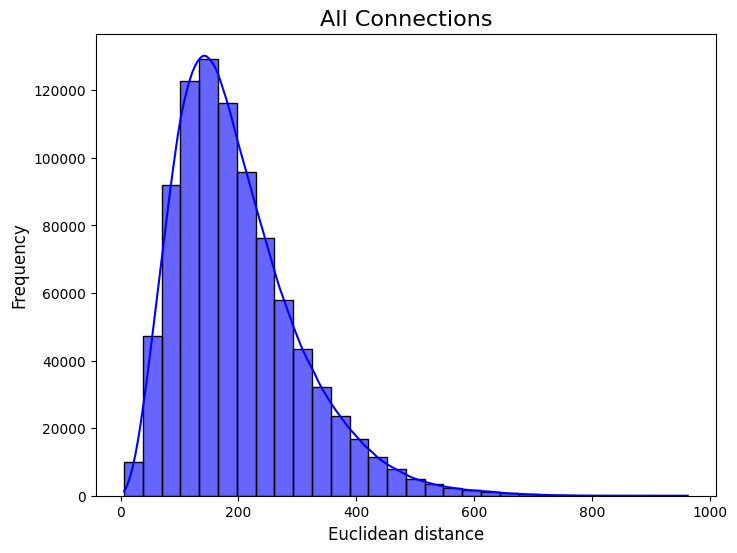

In [38]:
#Visualize euclidean distance distribution
#connectivity_ct_df_ecldn['euclidean_distance'].plot.hist(bins=5, color='orange', edgecolor='black')

plt.figure(figsize=(8, 6))
sns.histplot(connectivity_ct_df_ecldn['euclidean_distance'], kde=True, bins=30, color='blue', alpha=0.6, edgecolor='black')

# Show the plot
# Add labels and title
plt.title('All Connections', fontsize=16)
plt.xlabel('Euclidean distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Save the figure as a PNG file
plt.savefig(f"/results/elcdn_all.png", dpi=300)

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

#### I to E connections


In [32]:
# find I to E connections

connectivity_ct_IE = connectivity_ct_df_ecldn.query('ei_pre == "I" and ei_post == "E"')
connectivity_ct_IE.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,target_structure,soma_depth_pre,ei_pre,cell_type_pre,pre_pt_position_trform_x,pre_pt_position_trform_y,pre_pt_position_trform_z,soma_depth_post,ei_post,cell_type_post,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z,euclidean_distance
467,864691132536286810,864691132533674330,1,632,632.0,shaft,481.95328,I,DTC,-68.294259,481.95328,-64.04816,567.751153,E,L6-IT,298.230016,567.751153,-122.546199,380.950574
468,864691132536286810,864691132533674330,1,402,402.0,spine,481.95328,I,DTC,-68.294259,481.95328,-64.04816,567.751153,E,L6-IT,298.230016,567.751153,-122.546199,380.950574
469,864691132536286810,864691132534151258,1,303,303.0,shaft,481.95328,I,DTC,-68.294259,481.95328,-64.04816,422.696281,E,L5-ET,-51.898382,422.696281,-120.886490,83.730594
470,864691132536286810,864691132543923601,1,1756,1756.0,shaft,481.95328,I,DTC,-68.294259,481.95328,-64.04816,759.027470,E,L6-CT,20.438436,759.027470,-142.416355,301.305778
471,864691132536286810,864691132545911106,2,2581,1290.5,shaft,481.95328,I,DTC,-68.294259,481.95328,-64.04816,122.811096,E,L2-IT,-9.122581,122.811096,-137.319041,371.285628


In [33]:
connectivity_ct_IE["cell_type_post"].value_counts()

cell_type_post
L3-IT    189002
L2-IT    114966
L4-IT     99704
L6-CT     69452
L5-IT     47542
L6-IT     46830
L5-ET     42676
L5-NP      2267
Name: count, dtype: int64

In [34]:
connectivity_ct_IE["cell_type_pre"].value_counts()

cell_type_pre
PTC    317521
DTC    256678
STC     25821
ITC     12419
Name: count, dtype: int64

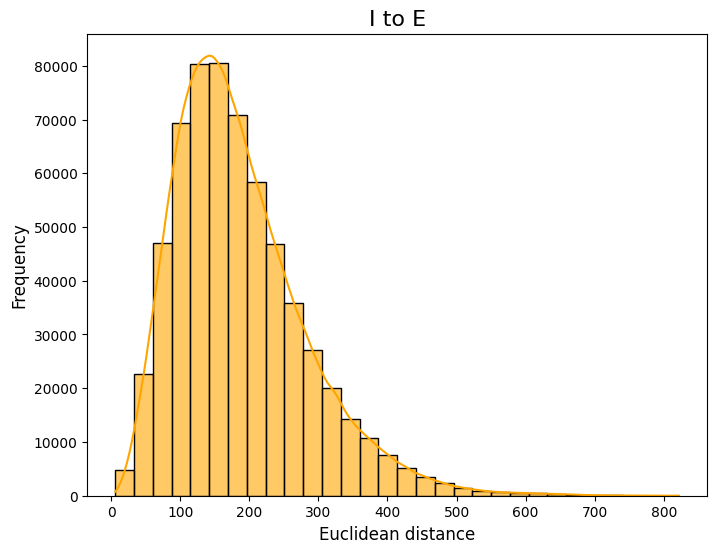

In [39]:
#Visualize euclidean distance distribution
#connectivity_ct_df_ecldn['euclidean_distance'].plot.hist(bins=5, color='orange', edgecolor='black')

plt.figure(figsize=(8, 6))
sns.histplot(connectivity_ct_IE['euclidean_distance'], kde=True, bins=30, color='orange', alpha=0.6, edgecolor='black')

# Show the plot
# Add labels and title
plt.title('I to E', fontsize=16)
plt.xlabel('Euclidean distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Save the figure as a PNG file
plt.savefig(f"/results/elcdn_IE.png", dpi=300)

plt.show()

In [36]:
# Count the number of each inhibtory presynaaptic cell type connection

# query dataframe to count the number of inhibitory cell connections
queried_connectivity_ct_IE = (
    connectivity_ct_IE.groupby(["post_pt_root_id","ei_pre","ei_post","cell_type_pre", "cell_type_post","target_structure"])
    .agg(num_connections=("cell_type_pre", "count"),
         total_synapses=("num_synapses", "sum"),
         sum_size = ("sum_size", "sum"),
         #syn_ratio = ("synaptic_ratio", "mean"),
         avg_eucl_dist = ("euclidean_distance", "mean")
         )
    .reset_index()  
)

queried_connectivity_ct_IE.head()

,post_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,avg_eucl_dist
0,864691132533275738,I,E,DTC,L4-IT,shaft,7,12,5774,227.569473
1,864691132533275738,I,E,DTC,L4-IT,spine,3,4,2550,217.335491
2,864691132533275738,I,E,PTC,L4-IT,shaft,1,2,2883,277.058041
3,864691132533275738,I,E,PTC,L4-IT,spine,1,1,435,241.857691
4,864691132533347418,I,E,DTC,L4-IT,shaft,19,38,16095,160.687044


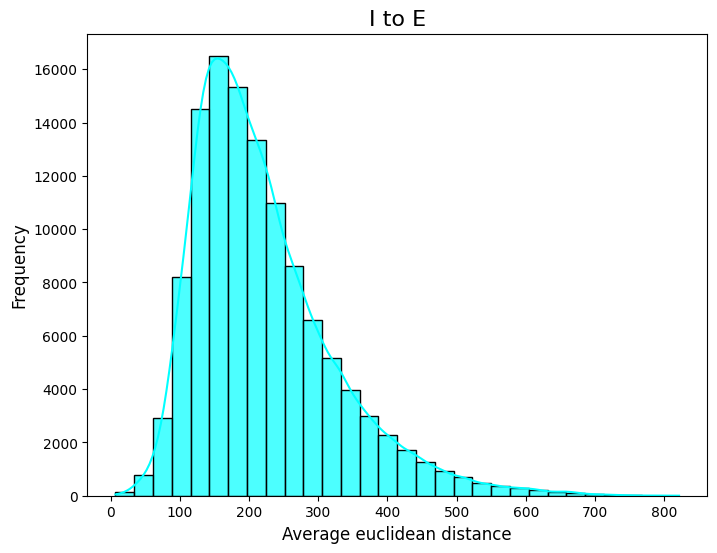

In [40]:
#Visualize euclidean distance distribution
#connectivity_ct_df_ecldn['euclidean_distance'].plot.hist(bins=5, color='orange', edgecolor='black')

plt.figure(figsize=(8, 6))
sns.histplot(queried_connectivity_ct_IE['avg_eucl_dist'], kde=True, bins=30, color='cyan', alpha=0.7, edgecolor='black')

# Show the plot
# Add labels and title
plt.title('I to E', fontsize=16)
plt.xlabel('Average euclidean distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Save the figure as a PNG file
plt.savefig(f"/results/elcdn_IE.png", dpi=300)

plt.show()

In [44]:
# add the synaptic ratio - divide sum_size by number of synapses
queried_connectivity_ct_IE["syn_ratio"] = queried_connectivity_ct_IE["sum_size"]/queried_connectivity_ct_IE["total_synapses"]
queried_connectivity_ct_IE.head()

,post_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,avg_eucl_dist,syn_ratio
0,864691132533275738,I,E,DTC,L4-IT,shaft,7,12,5774,227.569473,481.166667
1,864691132533275738,I,E,DTC,L4-IT,spine,3,4,2550,217.335491,637.500000
2,864691132533275738,I,E,PTC,L4-IT,shaft,1,2,2883,277.058041,1441.500000
3,864691132533275738,I,E,PTC,L4-IT,spine,1,1,435,241.857691,435.000000
4,864691132533347418,I,E,DTC,L4-IT,shaft,19,38,16095,160.687044,423.552632


In [45]:
# Swap column 'syn_ratio' to the seventh position
col = queried_connectivity_ct_IE.pop('syn_ratio')
queried_connectivity_ct_IE.insert(9, 'syn_ratio', col)

queried_connectivity_ct_IE.head()

,post_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,syn_ratio,avg_eucl_dist
0,864691132533275738,I,E,DTC,L4-IT,shaft,7,12,5774,481.166667,227.569473
1,864691132533275738,I,E,DTC,L4-IT,spine,3,4,2550,637.500000,217.335491
2,864691132533275738,I,E,PTC,L4-IT,shaft,1,2,2883,1441.500000,277.058041
3,864691132533275738,I,E,PTC,L4-IT,spine,1,1,435,435.000000,241.857691
4,864691132533347418,I,E,DTC,L4-IT,shaft,19,38,16095,423.552632,160.687044


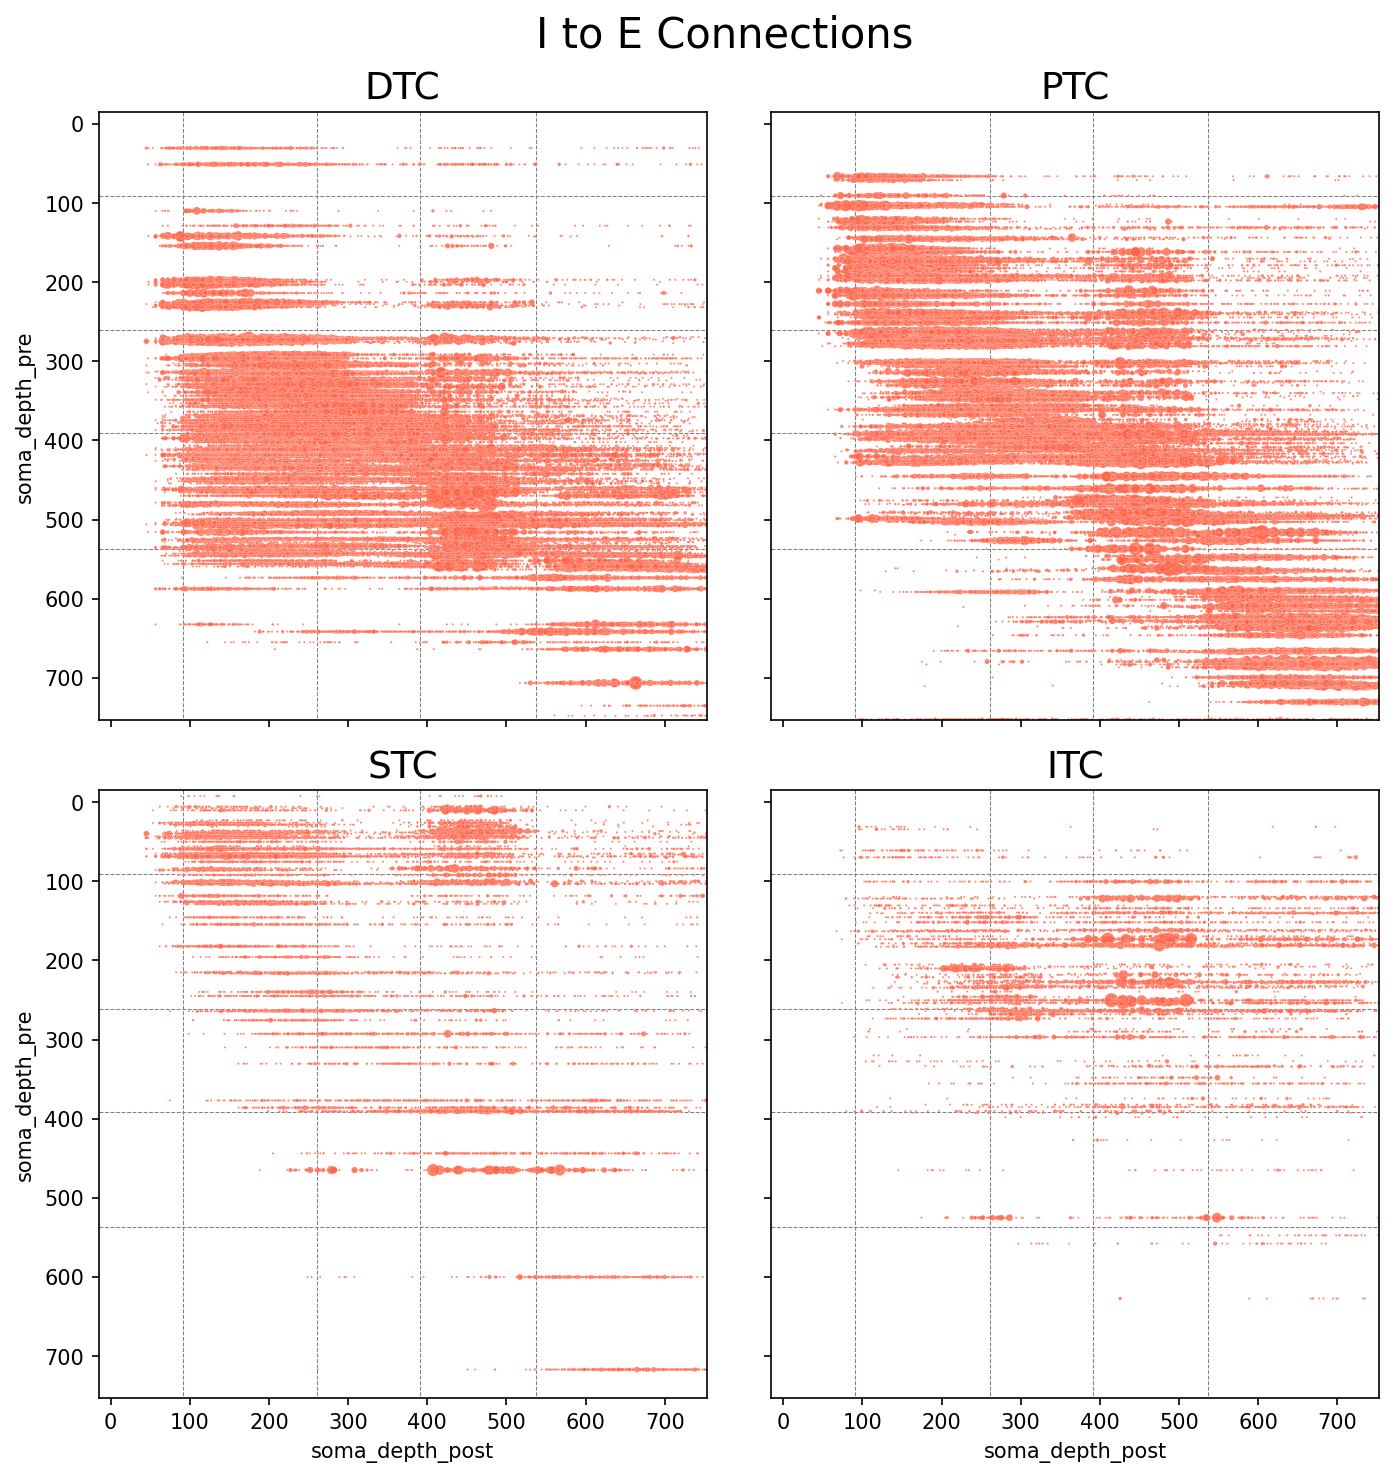

In [47]:
# visualize the IE synaptic connectivity across layer depth

fig, axes = plt.subplots(
    figsize=(10, 10),
    ncols=2,
    nrows=2,
    sharex=True,
    sharey=True,
    dpi=150,
    tight_layout=True,
)

ie_palette = {"I": "tomato", "E": "navy"}
ct_type = [["DTC", "PTC"], ["STC", "ITC"]]
#print(x)

for pre_ind in [0, 1]:
    for post_ind in [0, 1]:
        ax = axes[pre_ind, post_ind]
        #pre_cat = ct_category[pre_ind]
        #post_cat = ct_category[post_ind]
        cell_type = ct_type[pre_ind][post_ind]
        sns.scatterplot(
            data=connectivity_ct_IE.query(
                'cell_type_pre == @cell_type'
            ),
            x="soma_depth_post",
            y="soma_depth_pre",
            #hue="pre_pt_root_id",
            #data = connectivity_ct_df.query('ei_pre == "I" and ei_post == "E" and cell_type_post == @cell_type'),
            hue="ei_pre",
            ax=ax,
            size="num_synapses",
            sizes=(1, 50),
            size_norm=(1, 30),  # Sets the value range mapping to the range in "sizes".
            legend=False,
            palette=ie_palette,
            alpha=0.8,
        )

        ax.set_xlim(layer_bounds[0], layer_bounds[-1])
        ax.set_ylim(layer_bounds[0], layer_bounds[-1])
        ax.set_aspect("equal")

        ax.set_title(f"{cell_type}",fontsize = 18)

        # add horizontal and vertical lines where layers are
        ax.hlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )  # The `zorder` parameter puts the lines behind the scatter points
        ax.vlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )

ax.invert_yaxis()
plt.suptitle("I to E Connections", fontsize = 20)

# Save the figure as a PNG file
plt.savefig(f"/results/ItoE_synapticConnections.png")


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

##### Proportions of synapses onto target structures

In [48]:
group_structure_counts = connectivity_ct_IE.groupby(
    ["cell_type_pre", "cell_type_post", "target_structure"],
    as_index=False,
).size()
group_structure_counts

,cell_type_pre,cell_type_post,target_structure,size
0,DTC,L2-IT,shaft,33583
1,DTC,L2-IT,soma,92
2,DTC,L2-IT,spine,15108
3,DTC,L2-IT,unknown,9
4,DTC,L3-IT,shaft,66863
...,...,...,...,...
113,STC,L6-CT,soma,38
114,STC,L6-CT,spine,314
115,STC,L6-IT,shaft,1039
116,STC,L6-IT,soma,164


In [49]:
group_total_counts = (
    group_structure_counts.groupby(["cell_type_pre", "cell_type_post"], as_index=False)[
        "size"
    ]
    .sum()
    .rename(columns={"size": "total_size"})
)

group_total_counts
# OR


,cell_type_pre,cell_type_post,total_size
0,DTC,L2-IT,48792
1,DTC,L3-IT,96608
2,DTC,L4-IT,53876
3,DTC,L5-ET,14239
4,DTC,L5-IT,16767
5,DTC,L5-NP,1373
6,DTC,L6-CT,10643
7,DTC,L6-IT,14380
8,ITC,L2-IT,546
9,ITC,L3-IT,2583


In [50]:
# merge the two group dataframes
group_counts = pd.merge(
    group_structure_counts,
    group_total_counts,
    on=["cell_type_pre", "cell_type_post"],
)
group_counts

,cell_type_pre,cell_type_post,target_structure,size,total_size
0,DTC,L2-IT,shaft,33583,48792
1,DTC,L2-IT,soma,92,48792
2,DTC,L2-IT,spine,15108,48792
3,DTC,L2-IT,unknown,9,48792
4,DTC,L3-IT,shaft,66863,96608
...,...,...,...,...,...
113,STC,L6-CT,soma,38,1155
114,STC,L6-CT,spine,314,1155
115,STC,L6-IT,shaft,1039,1569
116,STC,L6-IT,soma,164,1569


In [52]:
group_counts["proportion"] = group_counts["size"] / group_counts["total_size"]
group_counts

,cell_type_pre,cell_type_post,target_structure,size,total_size,proportion
0,DTC,L2-IT,shaft,33583,48792,0.688289
1,DTC,L2-IT,soma,92,48792,0.001886
2,DTC,L2-IT,spine,15108,48792,0.309641
3,DTC,L2-IT,unknown,9,48792,0.000184
4,DTC,L3-IT,shaft,66863,96608,0.692106
...,...,...,...,...,...,...
113,STC,L6-CT,soma,38,1155,0.032900
114,STC,L6-CT,spine,314,1155,0.271861
115,STC,L6-IT,shaft,1039,1569,0.662205
116,STC,L6-IT,soma,164,1569,0.104525


In [53]:
# to make our plot look nicer, this code just reorders the categories to be first by
# excitatory/inhibitory, then by layer, and finally by cell type
categories = [
    "L2-IT",  # excitatory cell types
    "L3-IT",
    "L4-IT",
    "L5-IT",
    "L5-ET",
    "L5-NP",
    "L6-IT",
    "L6-CT",
    "DTC",  # inhibitory cell types
    "ITC",
    "PTC",
    "STC",
]

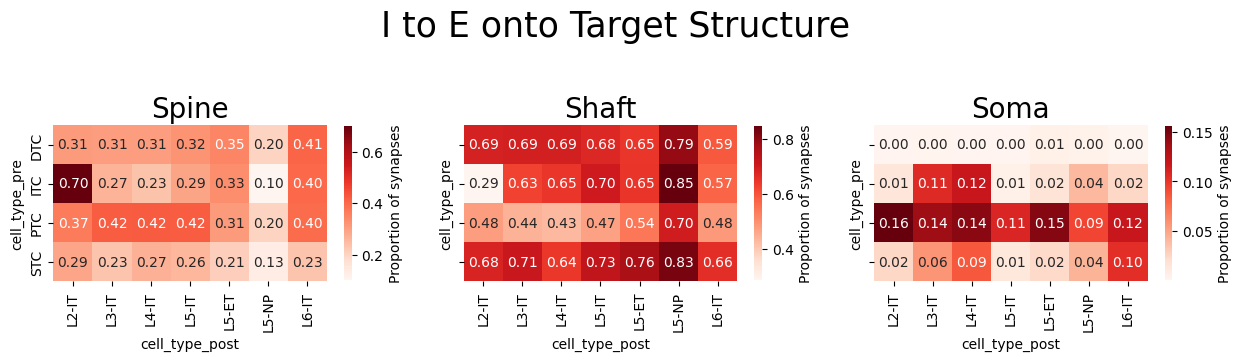

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True) #, layout="constrained")

for i, target_structure in enumerate(["spine", "shaft", "soma"]):
    square_counts = group_counts.query(
        f"target_structure == '{target_structure}'"
    ).pivot(index="cell_type_pre", columns="cell_type_post", values="proportion")

    square_counts = square_counts.reindex(index=categories[-4:], columns=categories[:7])

    sns.heatmap(
        square_counts,
        annot=True,
        cmap="Reds",
        ax=axs[i],
        square=True,
        cbar= True, #(i == len(axs) - 1), 
        cbar_kws=  {"label": "Proportion of synapses", 'shrink': 0.5},
        #cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4]),
        #cbar_ax=None if i < len(axes) - 1 else fig.add_axes([0.92, 0.3, 0.02, 0.4]),
        fmt=".2f",  # format the annotations to 2 decimal places
    )

    axs[i].set_title(target_structure.capitalize(),fontsize = 20)
    
#axs[2].set_cbar_kws({"label": "Proportion of synapses onto " + target_structure})
plt.suptitle("I to E onto Target Structure", fontsize = 25)

# Save the figure as a PNG file
plt.savefig(f"/results/ItoE_targetStructure.png")

In [ ]:
ct_type = [["DTC", "PTC"], ["STC", "ITC"]]
np.array(ct_type).shape
print(ct_type[1][0])

In [ ]:
ct_type[pre_ind][post_ind]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

#### E to I connections


In [ ]:
# find E to I connections
connectivity_ct_EI = connectivity_ct_df.query('ei_pre == "E" and ei_post == "I"')
connectivity_ct_EI.head()


In [ ]:
len(connectivity_ct_EI)

In [ ]:
# count unique post_opt_root_ids
connectivity_ct_IE['post_pt_root_id'].value_counts()

In [ ]:
connectivity_ct_IE['post_pt_root_id'].unique()

In [ ]:
# Keep only matching IDs
A,B = connectivity_ct_IE.copy(), connectivity_ct_EI.copy()

matching_root_ids = A[A["post_pt_root_id"].isin(B["pre_pt_root_id"])]["post_pt_root_id"].unique()

print(len(matching_root_ids))
#print()
print("Matching IDs:", matching_root_ids)
#matching_root_ids.value_counts()

In [ ]:
# index the matching IDs from postynaptic IE into EI connections
# thus  where IE post_pt_root_id == EI pre_pt_root_id 
# checking from EI unique connections to make sure there are 673 matching IDS

matching_root_ids = B[B["pre_pt_root_id"].isin(A["post_pt_root_id"])]["pre_pt_root_id"].unique()
print(len(matching_root_ids))

connectivity_ct_IE_EI_mgd = B[B["pre_pt_root_id"].isin(A["post_pt_root_id"])]
print(len(connectivity_ct_IE_EI_mgd))
print(connectivity_ct_IE_EI_mgd.shape)
connectivity_ct_IE_EI_mgd.head()

#B[A["post_pt_root_id"].isin(B["pre_pt_root_id"])]

In [ ]:
# another way - not my favorite due to the duplication of information
# merge IE and EI dataframes where where IE post_pt_root_id == EI pre_pt_root_id 
connectivity_ct_IE_EI_mgd = pd.merge(connectivity_ct_IE, connectivity_ct_EI,
                                        left_on='post_pt_root_id', right_on='pre_pt_root_id')
 
print(len(connectivity_ct_IE_EI_mgd))
connectivity_ct_IE_EI_mgd.head()


In [ ]:
connectivity_ct_IE_EI_mgd.columns

In [ ]:
connectivity_ct_IE_EI_mgd["cell_type_pre"].value_counts()

In [ ]:
connectivity_ct_IE_EI_mgd["cell_type_post"].value_counts()

In [ ]:
# Count the number of each inhibtory postsynaaptic cell type connection
# query dataframe to count the number of inhibitory cell connections
queried_connectivity_ct_EI = (
    connectivity_ct_IE_EI_mgd.groupby(["pre_pt_root_id","ei_pre","ei_post","cell_type_pre","cell_type_post","target_structure"])
    .agg(num_connections=("cell_type_post", "count"),
        total_synapses=("num_synapses", "sum"),
         sum_size = ("sum_size", "sum"),
         #syn_ratio = ("synaptic_ratio", "mean"),
         avg_eucl_dist = ("avg_eucl_dist", "mean")
         )
    .reset_index()  
)


queried_connectivity_ct_EI.head()

In [ ]:
# add the synaptic ratio - divide sum_size by number of synapses
queried_connectivity_ct_EI["syn_ratio"] = queried_connectivity_ct_EI["sum_size"]/queried_connectivity_ct_EI["total_synapses"]
queried_connectivity_ct_EI.head()

In [ ]:
# Swap column 'syn_ratio' to the 8th position
col = queried_connectivity_ct_EI.pop('syn_ratio')
queried_connectivity_ct_EI.insert(9, 'syn_ratio', col)

queried_connectivity_ct_EI.head()

In [ ]:
# visualize the EI synaptic connectivity across layer depth

fig, axes = plt.subplots(
    figsize=(10, 10),
    ncols=2,
    nrows=2,
    sharex=True,
    sharey=True,
    dpi=150,
    tight_layout=True,
)

ei_palette = {"E": "navy", "I": "tomato"}
ct_type = [["DTC", "PTC"], ["STC", "ITC"]]
#print(x)

for pre_ind in [0, 1]:
    for post_ind in [0, 1]:
        ax = axes[pre_ind, post_ind]
        #pre_cat = ct_category[pre_ind]
        #post_cat = ct_category[post_ind]
        cell_type = ct_type[pre_ind][post_ind]
        sns.scatterplot(
            data=connectivity_ct_IE_EI_mgd.query(
                'cell_type_post == @cell_type'
            ),
            x="soma_depth_post",
            y="soma_depth_pre",
            #hue="pre_pt_root_id",
            #data = connectivity_ct_df.query('ei_pre == "I" and ei_post == "E" and cell_type_post == @cell_type'),
            hue="ei_pre",
            ax=ax,
            size="num_synapses",
            sizes=(1, 50),
            size_norm=(1, 30),  # Sets the value range mapping to the range in "sizes".
            legend=False,
            palette=ei_palette,
            alpha=0.8,
        )

        ax.set_xlim(layer_bounds[0], layer_bounds[-1])
        ax.set_ylim(layer_bounds[0], layer_bounds[-1])
        ax.set_aspect("equal")

        ax.set_title(f"{cell_type}",fontsize = 18)

        # add horizontal and vertical lines where layers are
        ax.hlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )  # The `zorder` parameter puts the lines behind the scatter points
        ax.vlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )

ax.invert_yaxis()
plt.suptitle("E to I Connections", fontsize = 20)

# Save the figure as a PNG file
plt.savefig(f"/results/EtoI_synapticConnections.png")


In [ ]:
data_dir

In [46]:
# save the IE and EI data 

queried_connectivity_ct_IE.to_feather(f"/data/axonI_dndrtE_struct_cell_tbl_v1dd_{mat_version}.feather",
                                     compression="zstd")

#queried_connectivity_ct_EI
#np.save(f"{data_dir}/proofread_axon_list_{mat_version}.npy", axon_proof_root_ids)


In [ ]:
queried_connectivity_ct_EI.to_feather(f"/data/EI_struct_cell_tbl_v1dd_{mat_version}.feather",
                                      compression="zstd")
